In [1]:
!pip install pytorch==1.1.0 torchvision==0.3.0 cudatoolkit==9.0

  Could not find a version that satisfies the requirement pytorch==1.1.0 (from versions: 0.1.2, 1.0.2)
No matching distribution found for pytorch==1.1.0


In [3]:
import cv2 
import numpy as np
import torch
import torch.optim as optim
import torch as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

### A kind note: the cell below have been taken from the following github, since I didn't find the data in my workspace so I had to execute the following codes
https://github.com/hanisalah/landmark_classification_and_tagging_for_social_media/blob/main/landmark.ipynb

In [4]:
#execute this cell only if data is not available at Udacity workspace (which is currently the default!)
#downloading data to Udacity Workspace (it is not there by default) and unzipping data.
import os
if (os.path.isdir('data')==False) or (len(os.listdir('data/landmark_images/train')) !=50):
    if os.path.isfile('landmark_images.zip')==False:
        import requests
        import zipfile
        url = 'https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip'
        r = requests.get(url, allow_redirects=True)
        open('landmark_images.zip', 'wb').write(r.content)
    with zipfile.ZipFile('landmark_images.zip', 'r') as zip_ref:
        zip_ref.extractall('data/')

- part of the calculations below have been taken from the below
https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

In [5]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# Here to identify the path of images 
train_d = "data/landmark_images/train"
test_d = "data/landmark_images/test"

## Transform the images and process it and normalize it here at this section
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

# Passing the images path and transform the images with our transformers 
train_set = datasets.ImageFolder(train_d, transform=transform)
test_set  = datasets.ImageFolder(test_d,  transform=transform)

train_size = len(train_set)
test_size = len(test_set)


print("Number of Training Images= ", train_size)
print("Number of Testing Images= ", test_size)

# from https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

valid_split = 0.2 
shuffle_dataset = True
indices = list(range(train_size))
random_seed= 42

# print(indices)

split = int(np.floor(valid_split * train_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

#print(train_indices)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Data Loader for Train, Validation and Testing 
train = nn.utils.data.DataLoader(train_set, batch_size= 32, sampler = train_sampler)
valid = nn.utils.data.DataLoader(train_set, batch_size= 32, sampler = valid_sampler)
test = nn.utils.data.DataLoader(test_set, batch_size = 32)


# Setting the loaders 
loaders_scratch = {'train': train, 'valid': valid, 'test': test}


Number of Training Images=  4996
Number of Testing Images=  1250


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)


# - Below I used the helper function that have been taken from udacity's classroom for CIFAR Data
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

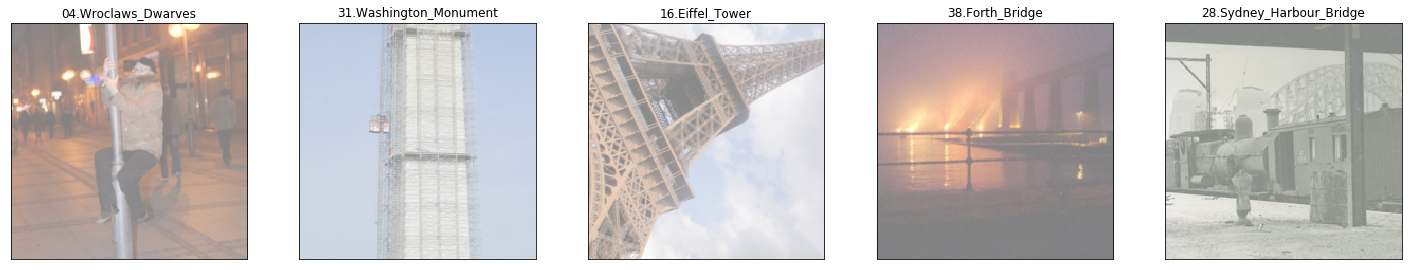

In [7]:
dataiter = iter(train)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 20))
# display 20 images
for idx in np.arange(5):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_set.classes[labels[idx]])

### Initialize use_cuda variable

In [8]:
# useful variable that tells us whether we should use the GPU
use_cuda = nn.cuda.is_available()
use_cuda

True

In [66]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
        # calculate the batch loss
            loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
        # perform a single optimization step (parameter update)
            optimizer.step()
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))


            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))


   
            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    torch.cuda.empty_cache()
    return model

In [67]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.normal_(0, y)
            m.bias.data.fill_(0)
    

In [73]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [20]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#loaders_transfer = {'train': train, 'valid': valid, 'test': test}
loaders_transfer= loaders_scratch.copy()

In [21]:
## TODO: select loss function
criterion_transfer = torch.nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.parameters(), lr=0.001)

In [22]:
from torchvision import datasets, models, transforms

In [23]:
## TODO: Specify model architecture
import torch.nn as nn
from torchvision import models

model_transfer = models.vgg16(pretrained=True)

#freezing features- weights
for x in model_transfer.features.parameters():
    x.require_grad =False
    
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(train_set.classes))

model_transfer.classifier[6] = last_layer
#print(model_transfer)

#-#-# Do NOT modify the code below this line. #-#-#
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 109793139.48it/s]


In [24]:
model_transfer.classifier[6].in_features

4096

In [25]:
#def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path)

In [26]:
import torch.nn.functional as F

In [24]:
num_e = 10

In [27]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
model_transfer =train(num_e, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
      criterion_transfer,
                      use_cuda ,
                      'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.778870 	Validation Loss: 3.441906
Validation loss decreased (inf --> 3.441906).  Saving model ...
Epoch: 2 	Training Loss: 3.001979 	Validation Loss: 2.433757
Validation loss decreased (3.441906 --> 2.433757).  Saving model ...
Epoch: 3 	Training Loss: 2.187671 	Validation Loss: 2.160005
Validation loss decreased (2.433757 --> 2.160005).  Saving model ...
Epoch: 4 	Training Loss: 1.769164 	Validation Loss: 1.795588
Validation loss decreased (2.160005 --> 1.795588).  Saving model ...
Epoch: 5 	Training Loss: 1.488301 	Validation Loss: 1.705985
Validation loss decreased (1.795588 --> 1.705985).  Saving model ...
Epoch: 6 	Training Loss: 1.312750 	Validation Loss: 1.009133
Validation loss decreased (1.705985 --> 1.009133).  Saving model ...
Epoch: 7 	Training Loss: 1.165707 	Validation Loss: 0.909918
Validation loss decreased (1.009133 --> 0.909918).  Saving model ...
Epoch: 8 	Training Loss: 1.050461 	Validation Loss: 1.006338
Epoch: 9 	Training Loss: 0.934662 

In [27]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [29]:
from torch.utils.data import DataLoader, Dataset

In [30]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.978645


Test Accuracy: 73% (923/1250)


In [36]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    imag_e = Image.open(img_path)
    
    transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
    
    imag_e = transform(imag_e)
    imag_e.unsqueeze_(0)
    
    
    if use_cuda:
        imag_e = imag_e.cuda()
        
    evalu = model_transfer
    evalu.eval()
    
    
    results = evalu(imag_e)
    val, ind = results.topk(k)
    
    
    top_k = []
    
    for i in ind[0].tolist():
        top_k.append(train_set.classes[i])
        
    evalu.train()
    
    return top_k
    
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['09.Golden_Gate_Bridge',
 '38.Forth_Bridge',
 '30.Brooklyn_Bridge',
 '28.Sydney_Harbour_Bridge',
 '26.Pont_du_Gard']

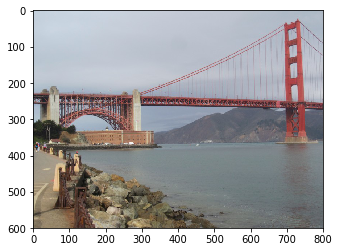

The place is one of the following: 09.Golden_Gate_Bridge or 38.Forth_Bridge or 30.Brooklyn_Bridge


In [41]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    imag_e = Image.open(img_path)
    plt.imshow(imag_e)
    plt.show()
    print("The place is one of the following:",predicted_landmarks[0], 'or', predicted_landmarks[1], 'or', predicted_landmarks[2])
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

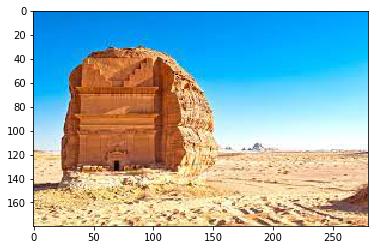

The place is one of the following: 18.Delicate_Arch or 36.Badlands_National_Park or 32.Hanging_Temple


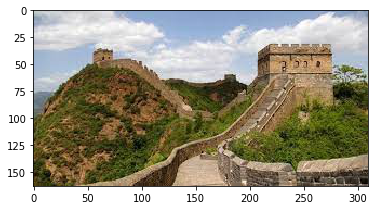

The place is one of the following: 10.Edinburgh_Castle or 41.Machu_Picchu or 46.Great_Wall_of_China


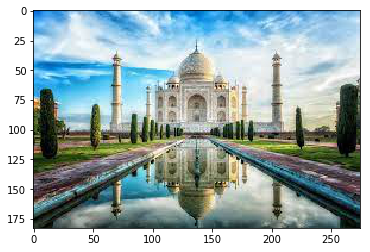

The place is one of the following: 19.Vienna_City_Hall or 21.Taj_Mahal or 40.Stockholm_City_Hall


In [43]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.



suggest_locations('Suggested Images/SA.jpg')

suggest_locations('Suggested Images/CH.jpg')


suggest_locations('Suggested Images/IND.jpg')


